### Predicting S&P500 stock returns: generate test results

This program uses a neural network that was built by randomly searching parameter space to find the optimal parameter values. It generates model predictions for each date that's in the test set. The model starts with an 80% training (10% of which is used for validation) and 20% testing split on the time-sorted dataset. Earlier dates are used for training. It then trains the model using the first training / development set and uses that model to predict outcomes for the first test date. After this step, the program adds the test date to the training/validation set, and retrains the network using its current parameters as initial values.

The results (predictions for each ticker + date, class probabilities, and benchmark predictions) are saved in a CSV file. Also, the main step generates classification reports and confusion matrices.

March 2018

Murat Aydogdu

In [2]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from collections import Counter
import time
import random

In [6]:
# Neural net predictions
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
pd.options.display.float_format = '{:20,.4f}'.format

In [10]:
# SMOTE synthetically creates new observations from underrepresented categories.
# This improves model training since the model sees similar number of examples from each class
#!pip install -U imbalanced-learn

from imblearn.over_sampling import SMOTE 

In [11]:
pd.set_option('mode.chained_assignment', None)

## Forming the training, testing, and validation data sets



### Stock returns



In [12]:
dflong = pd.read_csv("SP500_Long_V3.CSV")#.sample(frac=0.4)
print dflong.shape

(72802, 122)


In [13]:
# This piece of code uses index data
# The final version of the paper excludes this data
indices = pd.read_csv("Indices_Wide_V3.CSV")
print indices.shape
#indices.Date.unique()
# Only keep SPY returns
d_col = ['Date']
spy_cols = [col for col in indices if ((col.find('SPY') > -1) & (col.find('RT') > -1))]
print spy_cols
indices = indices[d_col + spy_cols]
#display(indices)
# merge etf returns and volumes (market data)
dflong = dflong.merge(indices, how='left', on='Date', sort=False)
print dflong.shape
display(dflong)

(178, 157)
['RT SPY', 'RT01 SPY', 'RT02 SPY', 'RT03 SPY', 'RT04 SPY', 'RT05 SPY', 'RT06 SPY', 'RT07 SPY', 'RT08 SPY', 'RT09 SPY', 'RT10 SPY', 'RT11 SPY', 'RT12 SPY']
(72802, 135)


,Ticker,Date,V,P,AV,R,DRSD,YR,R01,R02,...,RT03 SPY,RT04 SPY,RT05 SPY,RT06 SPY,RT07 SPY,RT08 SPY,RT09 SPY,RT10 SPY,RT11 SPY,RT12 SPY
0,A,2003-11-26,41.8300,19.1200,76.6760,0.1630,0.0178,-0.0026,0.0830,-0.0916,...,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,-1.1834,0.8006,0.0323
1,A,2003-12-26,13.2200,19.0700,61.1830,-0.0026,0.0166,0.2916,0.1630,0.0830,...,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,-1.1834,0.8006
2,A,2004-01-27,790.5600,24.6300,138.7625,0.2916,0.0226,-0.0597,-0.0026,0.1630,...,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,-1.1834
3,A,2004-02-25,88.0800,23.1600,129.9435,-0.0597,0.0214,-0.1377,0.2916,-0.0026,...,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142
4,A,2004-03-24,113.9700,19.9700,107.8090,-0.1377,0.0276,0.0035,-0.0597,0.2916,...,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076
5,A,2004-04-22,78.6300,20.0400,77.3330,0.0035,0.0212,-0.1727,-0.1377,-0.0597,...,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923
6,A,2004-05-20,96.8400,16.5800,92.1400,-0.1727,0.0155,0.0525,0.0035,-0.1377,...,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143
7,A,2004-06-21,41.2900,17.4500,75.9650,0.0525,0.0163,0.0080,-0.1727,0.0035,...,-1.6283,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001
8,A,2004-07-20,78.6600,17.5900,78.5570,0.0080,0.0253,-0.1779,0.0525,-0.1727,...,0.6623,-1.6283,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796
9,A,2004-08-17,69.5400,14.4600,77.4715,-0.1779,0.0353,0.0560,0.0080,0.0525,...,-1.3232,0.6623,-1.6283,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396


In [ ]:
# PERFECT HINDSIGHT
# Use 33% and 67% cutoffs to obtain three-level prediction
#dflong['Q33'] = dflong.groupby(['Date'])['R'].transform(lambda x: x.quantile(.33))
#dflong['Q67'] = dflong.groupby(['Date'])['R'].transform(lambda x: x.quantile(.67))
#dflong['Y'] = 1 # default
#dflong['Y'][dflong['R'] >= dflong['Q67']] = 2
#dflong['Y'][dflong['R'] <= dflong['Q33']] = 0
#dflong.drop(['Q33', 'Q67'], axis = 1)

In [14]:
# Use 33% and 67% cutoffs to obtain three-level prediction
dflong['Q33'] = dflong.groupby(['Date'])['YR'].transform(lambda x: x.quantile(.33))
dflong['Q67'] = dflong.groupby(['Date'])['YR'].transform(lambda x: x.quantile(.67))
dflong['Y'] = 1 # default
dflong['Y'][dflong['YR'] >= dflong['Q67']] = 2
dflong['Y'][dflong['YR'] <= dflong['Q33']] = 0
dflong.drop(['Q33', 'Q67'], axis = 1)

,Ticker,Date,V,P,AV,R,DRSD,YR,R01,R02,...,RT04 SPY,RT05 SPY,RT06 SPY,RT07 SPY,RT08 SPY,RT09 SPY,RT10 SPY,RT11 SPY,RT12 SPY,Y
0,A,2003-11-26,41.8300,19.1200,76.6760,0.1630,0.0178,-0.0026,0.0830,-0.0916,...,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,-1.1834,0.8006,0.0323,0
1,A,2003-12-26,13.2200,19.0700,61.1830,-0.0026,0.0166,0.2916,0.1630,0.0830,...,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,-1.1834,0.8006,2
2,A,2004-01-27,790.5600,24.6300,138.7625,0.2916,0.0226,-0.0597,-0.0026,0.1630,...,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,-1.1834,0
3,A,2004-02-25,88.0800,23.1600,129.9435,-0.0597,0.0214,-0.1377,0.2916,-0.0026,...,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,0
4,A,2004-03-24,113.9700,19.9700,107.8090,-0.1377,0.0276,0.0035,-0.0597,0.2916,...,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0
5,A,2004-04-22,78.6300,20.0400,77.3330,0.0035,0.0212,-0.1727,-0.1377,-0.0597,...,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0
6,A,2004-05-20,96.8400,16.5800,92.1400,-0.1727,0.0155,0.0525,0.0035,-0.1377,...,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,1
7,A,2004-06-21,41.2900,17.4500,75.9650,0.0525,0.0163,0.0080,-0.1727,0.0035,...,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,1
8,A,2004-07-20,78.6600,17.5900,78.5570,0.0080,0.0253,-0.1779,0.0525,-0.1727,...,-1.6283,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0
9,A,2004-08-17,69.5400,14.4600,77.4715,-0.1779,0.0353,0.0560,0.0080,0.0525,...,0.6623,-1.6283,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,1


In [15]:
# All the fields in SP500_Long_V3.CSV
id_cols = ['Ticker','Date']
other_cols= ['V','P','AV','R','DRSD','YR']
y_col = ['Y']
raw_ret = ['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12']
raw_vol = ['AV01', 'AV02', 'AV03', 'AV04', 'AV05', 'AV06', 'AV07', 'AV08', 'AV09', 'AV10', 'AV11', 'AV12']
raw_drsd = ['DRSD01', 'DRSD02', 'DRSD03', 'DRSD04', 'DRSD05', 'DRSD06', 'DRSD07', 'DRSD08', 'DRSD09', 'DRSD10', 'DRSD11', 'DRSD12']
cs_ret = [col for col in dflong if col.startswith('RC')]
cs_vol = [col for col in dflong if col.startswith('AVC')]
cs_drsd = [col for col in dflong if col.startswith('SDC')]
ts_ret = [col for col in dflong if col.startswith('RT')]
ts_vol = [col for col in dflong if col.startswith('AVT')]
ts_drsd = [col for col in dflong if col.startswith('SDT')]
print id_cols, y_col, other_cols, raw_ret, raw_vol, raw_drsd, cs_ret, cs_vol, cs_drsd, ts_ret, ts_vol, ts_drsd, spy_cols
# If the index data is used: spy_cols (from previous step has the column list)

['Ticker', 'Date'] ['Y'] ['V', 'P', 'AV', 'R', 'DRSD', 'YR'] ['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12'] ['AV01', 'AV02', 'AV03', 'AV04', 'AV05', 'AV06', 'AV07', 'AV08', 'AV09', 'AV10', 'AV11', 'AV12'] ['DRSD01', 'DRSD02', 'DRSD03', 'DRSD04', 'DRSD05', 'DRSD06', 'DRSD07', 'DRSD08', 'DRSD09', 'DRSD10', 'DRSD11', 'DRSD12'] ['RC', 'RC01', 'RC02', 'RC03', 'RC04', 'RC05', 'RC06', 'RC07', 'RC08', 'RC09', 'RC10', 'RC11', 'RC12'] ['AVC', 'AVC01', 'AVC02', 'AVC03', 'AVC04', 'AVC05', 'AVC06', 'AVC07', 'AVC08', 'AVC09', 'AVC10', 'AVC11', 'AVC12'] ['SDC', 'SDC01', 'SDC02', 'SDC03', 'SDC04', 'SDC05', 'SDC06', 'SDC07', 'SDC08', 'SDC09', 'SDC10', 'SDC11', 'SDC12'] ['RT', 'RT01', 'RT02', 'RT03', 'RT04', 'RT05', 'RT06', 'RT07', 'RT08', 'RT09', 'RT10', 'RT11', 'RT12', 'RT SPY', 'RT01 SPY', 'RT02 SPY', 'RT03 SPY', 'RT04 SPY', 'RT05 SPY', 'RT06 SPY', 'RT07 SPY', 'RT08 SPY', 'RT09 SPY', 'RT10 SPY', 'RT11 SPY', 'RT12 SPY'] ['AVT', 'AVT01', 'AVT02', 'AVT03', 'AVT04', 

In [16]:
# All columns, reordered
dflong = dflong[id_cols + other_cols + y_col + raw_ret + raw_vol + raw_drsd + 
                cs_ret + cs_vol + cs_drsd + ts_ret + ts_vol + ts_drsd + spy_cols]

# All columns, reordered but exclude ts columns 
# as that information is going to come from the wide data merge
#dflong = dflong[id_cols + other_cols + y_col + cs_ret + cs_vol]
display(dflong)

,Ticker,Date,V,P,AV,R,DRSD,YR,Y,R01,...,RT03 SPY,RT04 SPY,RT05 SPY,RT06 SPY,RT07 SPY,RT08 SPY,RT09 SPY,RT10 SPY,RT11 SPY,RT12 SPY
0,A,2003-11-26,41.8300,19.1200,76.6760,0.1630,0.0178,-0.0026,0,0.0830,...,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,-1.1834,0.8006,0.0323
1,A,2003-12-26,13.2200,19.0700,61.1830,-0.0026,0.0166,0.2916,2,0.1630,...,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,-1.1834,0.8006
2,A,2004-01-27,790.5600,24.6300,138.7625,0.2916,0.0226,-0.0597,0,-0.0026,...,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,-1.1834
3,A,2004-02-25,88.0800,23.1600,129.9435,-0.0597,0.0214,-0.1377,0,0.2916,...,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142
4,A,2004-03-24,113.9700,19.9700,107.8090,-0.1377,0.0276,0.0035,0,-0.0597,...,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076
5,A,2004-04-22,78.6300,20.0400,77.3330,0.0035,0.0212,-0.1727,0,-0.1377,...,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923
6,A,2004-05-20,96.8400,16.5800,92.1400,-0.1727,0.0155,0.0525,1,0.0035,...,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143
7,A,2004-06-21,41.2900,17.4500,75.9650,0.0525,0.0163,0.0080,1,-0.1727,...,-1.6283,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001
8,A,2004-07-20,78.6600,17.5900,78.5570,0.0080,0.0253,-0.1779,0,0.0525,...,0.6623,-1.6283,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796
9,A,2004-08-17,69.5400,14.4600,77.4715,-0.1779,0.0353,0.0560,1,0.0080,...,-1.3232,0.6623,-1.6283,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396


Start:  12:52:14 03/13/18 UTC
2015-03-12 2003-11-26 2013-12-02 2013-12-31 2015-02-11
2015-03-12 (52872, 78) (6135, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(1, 'begin', array([[ 0.2836393 , -0.29039425,  0.28972453]], dtype=float32))
Early stopping at epoch   28: Best epoch   18: Validation error: 64.9% 
(1, 'last', array([[ 0.11169501, -0.04863993,  0.1666428 ]], dtype=float32))
Test_error: 70.4%
             precision    recall  f1-score   support

          0       0.31      0.33      0.32       135
          1       0.28      0.37      0.32       139
          2       0.30      0.18      0.22       135

avg / total       0.30      0.30      0.29       409

[[45 68 22]
 [52 52 35]
 [47 64 24]]


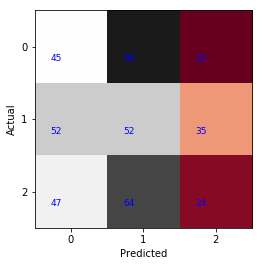

End:  12:54:59 03/13/18 UTC
Start:  12:54:59 03/13/18 UTC
2015-04-10 2003-11-26 2013-12-31 2014-01-30 2015-03-12
2015-04-10 (53289, 78) (6135, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.11169501, -0.04863993,  0.1666428 ]], dtype=float32))
Early stopping at epoch   24: Best epoch   14: Validation error: 65.1% 
(0, 'last', array([[ 0.10620981, -0.06452686,  0.18799601]], dtype=float32))
Test_error: 65.0%
             precision    recall  f1-score   support

          0       0.45      0.28      0.34       136
          1       0.24      0.07      0.11       138
          2       0.34      0.70      0.46       135

avg / total       0.34      0.35      0.30       409

[[ 38  17  81]
 [ 22  10 106]
 [ 25  15  95]]


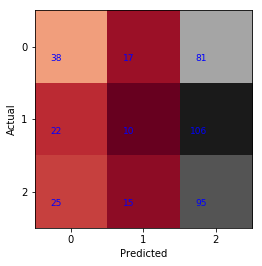

End:  12:57:47 03/13/18 UTC
Start:  12:57:47 03/13/18 UTC
2015-05-08 2003-11-26 2014-01-30 2014-02-28 2015-04-10
2015-05-08 (53706, 78) (6135, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.10620981, -0.06452686,  0.18799601]], dtype=float32))
Early stopping at epoch   13: Best epoch    3: Validation error: 64.8% 
(0, 'last', array([[ 0.10612255, -0.06678847,  0.1903357 ]], dtype=float32))
Test_error: 64.3%
             precision    recall  f1-score   support

          0       0.36      0.04      0.07       135
          1       0.33      0.55      0.41       139
          2       0.40      0.47      0.44       135

avg / total       0.36      0.36      0.31       409

[[ 5 92 38]
 [ 5 77 57]
 [ 4 67 64]]


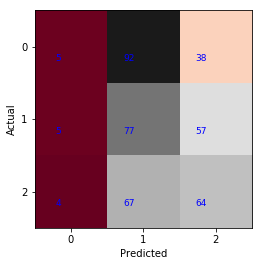

End:  13:00:21 03/13/18 UTC
Start:  13:00:21 03/13/18 UTC
2015-06-08 2003-11-26 2014-02-28 2014-03-28 2015-05-08
2015-06-08 (54123, 78) (6135, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.10612255, -0.06678847,  0.1903357 ]], dtype=float32))
Early stopping at epoch   17: Best epoch    7: Validation error: 64.6% 
(0, 'last', array([[ 0.09874026, -0.0716154 ,  0.20264918]], dtype=float32))
Test_error: 69.7%
             precision    recall  f1-score   support

          0       0.28      0.51      0.36       135
          1       0.40      0.22      0.29       139
          2       0.29      0.18      0.22       135

avg / total       0.32      0.30      0.29       409

[[69 27 39]
 [89 31 19]
 [91 20 24]]


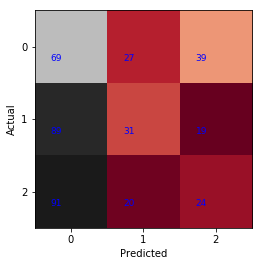

End:  13:03:03 03/13/18 UTC
Start:  13:03:03 03/13/18 UTC
2015-07-07 2003-11-26 2014-03-28 2014-04-28 2015-06-08
2015-07-07 (54540, 78) (6135, 78) (409, 78)
(0, 'begin', array([[ 0.09874026, -0.0716154 ,  0.20264918]], dtype=float32))


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

Early stopping at epoch   37: Best epoch   27: Validation error: 64.6% 
(0, 'last', array([[ 0.09147109, -0.08596262,  0.224183  ]], dtype=float32))
Test_error: 66.7%
             precision    recall  f1-score   support

          0       0.30      0.16      0.21       135
          1       0.38      0.50      0.43       139
          2       0.30      0.33      0.31       135

avg / total       0.32      0.33      0.32       409

[[22 50 63]
 [27 69 43]
 [25 65 45]]


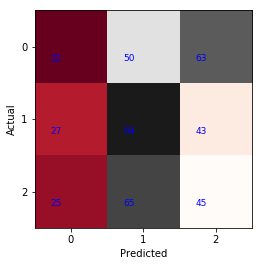

End:  13:05:52 03/13/18 UTC
Start:  13:05:52 03/13/18 UTC
2015-08-04 2003-11-26 2014-04-28 2014-05-27 2015-07-07
2015-08-04 (54954, 78) (6135, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.09147109, -0.08596262,  0.224183  ]], dtype=float32))
Early stopping at epoch   15: Best epoch    5: Validation error: 64.9% 
(0, 'last', array([[ 0.0943374 , -0.09021461,  0.2257285 ]], dtype=float32))
Test_error: 64.5%
             precision    recall  f1-score   support

          0       0.31      0.24      0.27       135
          1       0.38      0.50      0.43       139
          2       0.35      0.32      0.33       135

avg / total       0.35      0.35      0.35       409

[[32 56 47]
 [36 70 33]
 [34 58 43]]


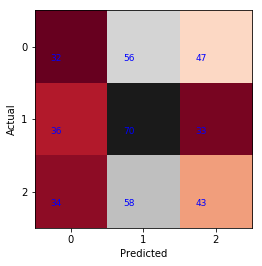

End:  13:08:22 03/13/18 UTC
Start:  13:08:22 03/13/18 UTC
2015-09-01 2003-11-26 2014-05-27 2014-06-24 2015-08-04
2015-09-01 (55362, 78) (6135, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.0943374 , -0.09021461,  0.2257285 ]], dtype=float32))
Early stopping at epoch   21: Best epoch   11: Validation error: 65.1% 
(0, 'last', array([[ 0.09019905, -0.09758855,  0.23681845]], dtype=float32))
Test_error: 61.9%
             precision    recall  f1-score   support

          0       0.32      0.21      0.26       135
          1       0.38      0.35      0.36       139
          2       0.41      0.59      0.48       135

avg / total       0.37      0.38      0.37       409

[[29 49 57]
 [36 48 55]
 [27 29 79]]


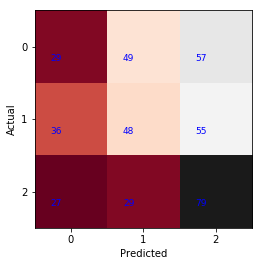

End:  13:11:01 03/13/18 UTC
Start:  13:11:01 03/13/18 UTC
2015-09-30 2003-11-26 2014-06-24 2014-07-23 2015-09-01
2015-09-30 (55776, 78) (6135, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.09019905, -0.09758855,  0.23681845]], dtype=float32))
Early stopping at epoch   15: Best epoch    5: Validation error: 64.9% 
(0, 'last', array([[ 0.08704326, -0.0974459 ,  0.23952563]], dtype=float32))
Test_error: 65.0%
             precision    recall  f1-score   support

          0       0.29      0.35      0.32       135
          1       0.32      0.40      0.36       139
          2       0.54      0.30      0.38       135

avg / total       0.38      0.35      0.35       409

[[47 68 20]
 [69 56 14]
 [46 49 40]]


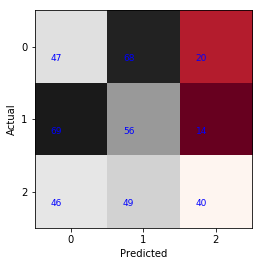

End:  13:13:43 03/13/18 UTC
Start:  13:13:43 03/13/18 UTC
2015-10-28 2003-11-26 2014-07-23 2014-08-20 2015-09-30
2015-10-28 (56193, 78) (6135, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.08704326, -0.0974459 ,  0.23952563]], dtype=float32))
Early stopping at epoch   41: Best epoch   31: Validation error: 64.7% 
(0, 'last', array([[ 0.06600833, -0.09509902,  0.2563361 ]], dtype=float32))
Test_error: 69.4%
             precision    recall  f1-score   support

          0       0.35      0.29      0.31       135
          1       0.32      0.35      0.33       139
          2       0.26      0.27      0.27       135

avg / total       0.31      0.31      0.31       409

[[39 44 52]
 [37 49 53]
 [37 61 37]]


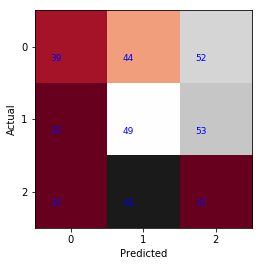

End:  13:16:49 03/13/18 UTC
Start:  13:16:49 03/13/18 UTC
2015-11-25 2003-11-26 2014-07-23 2014-08-20 2015-10-28
2015-11-25 (56193, 78) (6544, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.06600833, -0.09509902,  0.2563361 ]], dtype=float32))
Early stopping at epoch   26: Best epoch   16: Validation error: 64.9% 
(0, 'last', array([[ 0.05953758, -0.09841333,  0.26557228]], dtype=float32))
Test_error: 69.7%
             precision    recall  f1-score   support

          0       0.33      0.10      0.15       135
          1       0.20      0.14      0.17       139
          2       0.34      0.67      0.45       135

avg / total       0.29      0.30      0.25       409

[[ 13  54  68]
 [ 11  20 108]
 [ 16  28  91]]


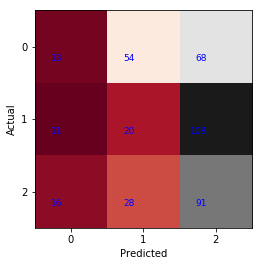

End:  13:19:30 03/13/18 UTC
Start:  13:19:30 03/13/18 UTC
2015-12-24 2003-11-26 2014-08-20 2014-09-18 2015-11-25
2015-12-24 (56610, 78) (6544, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.05953758, -0.09841333,  0.26557228]], dtype=float32))
Early stopping at epoch   17: Best epoch    7: Validation error: 65.4% 
(0, 'last', array([[ 0.05733614, -0.09652191,  0.26549688]], dtype=float32))
Test_error: 71.1%
             precision    recall  f1-score   support

          0       0.27      0.19      0.22       135
          1       0.34      0.19      0.24       139
          2       0.28      0.50      0.36       135

avg / total       0.30      0.29      0.27       409

[[25 19 91]
 [29 26 84]
 [37 31 67]]


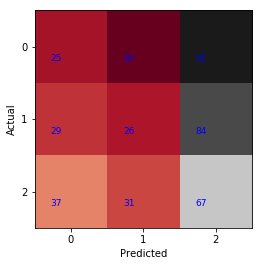

End:  13:22:24 03/13/18 UTC
Start:  13:22:24 03/13/18 UTC
2016-01-26 2003-11-26 2014-09-18 2014-10-16 2015-12-24
2016-01-26 (57024, 78) (6544, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.05733614, -0.09652191,  0.26549688]], dtype=float32))
Early stopping at epoch   17: Best epoch    7: Validation error: 65.7% 
(0, 'last', array([[ 0.05704685, -0.08902119,  0.25768262]], dtype=float32))
Test_error: 67.0%
             precision    recall  f1-score   support

          0       0.41      0.39      0.40       136
          1       0.23      0.14      0.17       138
          2       0.32      0.47      0.38       135

avg / total       0.32      0.33      0.32       409

[[53 28 55]
 [40 19 79]
 [37 35 63]]


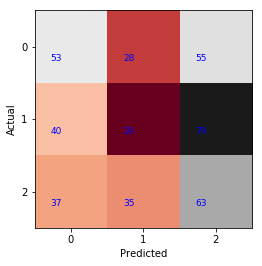

End:  13:25:07 03/13/18 UTC
Start:  13:25:07 03/13/18 UTC
2016-02-24 2003-11-26 2014-10-16 2014-11-13 2016-01-26
2016-02-24 (57441, 78) (6544, 78) (409, 78)
(0, 'begin', array([[ 0.05704685, -0.08902119,  0.25768262]], dtype=float32))


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

Early stopping at epoch   13: Best epoch    3: Validation error: 65.9% 
(0, 'last', array([[ 0.05853909, -0.09693484,  0.2640083 ]], dtype=float32))
Test_error: 63.1%
             precision    recall  f1-score   support

          0       0.36      0.70      0.48       135
          1       0.37      0.33      0.35       139
          2       0.42      0.08      0.14       135

avg / total       0.39      0.37      0.32       409

[[94 31 10]
 [88 46  5]
 [78 46 11]]


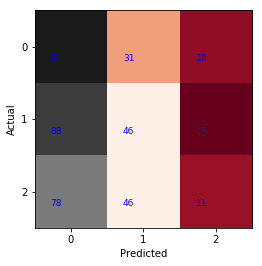

End:  13:27:45 03/13/18 UTC
Start:  13:27:45 03/13/18 UTC
2016-03-23 2003-11-26 2014-11-13 2014-12-12 2016-02-24
2016-03-23 (57858, 78) (6544, 78) (409, 78)
(0, 'begin', array([[ 0.05853909, -0.09693484,  0.2640083 ]], dtype=float32))


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

Early stopping at epoch   13: Best epoch    3: Validation error: 65.7% 
(0, 'last', array([[ 0.06299914, -0.09294951,  0.25543272]], dtype=float32))
Test_error: 71.1%
             precision    recall  f1-score   support

          0       0.25      0.12      0.17       136
          1       0.36      0.46      0.40       138
          2       0.23      0.28      0.25       135

avg / total       0.28      0.29      0.27       409

[[17 48 71]
 [20 63 55]
 [31 66 38]]


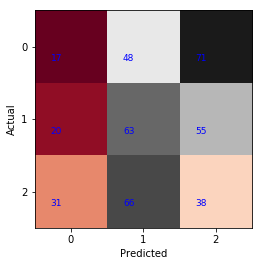

End:  13:30:29 03/13/18 UTC
Start:  13:30:29 03/13/18 UTC
2016-04-21 2003-11-26 2014-12-12 2015-01-13 2016-03-23
2016-04-21 (58275, 78) (6544, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.06299914, -0.09294951,  0.25543272]], dtype=float32))
Early stopping at epoch   13: Best epoch    3: Validation error: 66.4% 
(0, 'last', array([[ 0.05968926, -0.09085025,  0.25667626]], dtype=float32))
Test_error: 70.2%
             precision    recall  f1-score   support

          0       0.31      0.21      0.25       135
          1       0.32      0.22      0.26       139
          2       0.29      0.46      0.35       135

avg / total       0.30      0.30      0.29       409

[[29 26 80]
 [33 31 75]
 [33 40 62]]


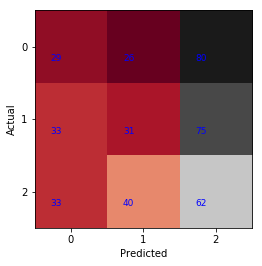

End:  13:33:11 03/13/18 UTC
Start:  13:33:11 03/13/18 UTC
2016-05-19 2003-11-26 2015-01-13 2015-02-11 2016-04-21
2016-05-19 (58689, 78) (6544, 78) (409, 78)
(0, 'begin', array([[ 0.05968926, -0.09085025,  0.25667626]], dtype=float32))


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

Early stopping at epoch   13: Best epoch    3: Validation error: 66.7% 
(0, 'last', array([[ 0.05609306, -0.09010805,  0.25951672]], dtype=float32))
Test_error: 64.5%
             precision    recall  f1-score   support

          0       0.36      0.30      0.33       135
          1       0.39      0.37      0.38       139
          2       0.32      0.40      0.36       135

avg / total       0.36      0.35      0.35       409

[[40 27 68]
 [41 51 47]
 [29 52 54]]


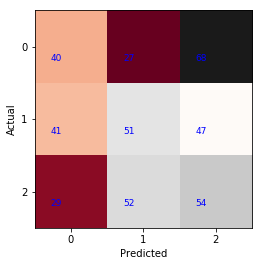

End:  13:36:03 03/13/18 UTC
Start:  13:36:03 03/13/18 UTC
2016-06-17 2003-11-26 2015-02-11 2015-03-12 2016-05-19
2016-06-17 (59106, 78) (6544, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.05609306, -0.09010805,  0.25951672]], dtype=float32))
Early stopping at epoch   18: Best epoch    8: Validation error: 66.5% 
(0, 'last', array([[ 0.06095818, -0.09526846,  0.25971842]], dtype=float32))
Test_error: 70.9%
             precision    recall  f1-score   support

          0       0.31      0.35      0.33       135
          1       0.31      0.35      0.33       139
          2       0.24      0.18      0.20       135

avg / total       0.28      0.29      0.29       409

[[47 52 36]
 [49 48 42]
 [57 54 24]]


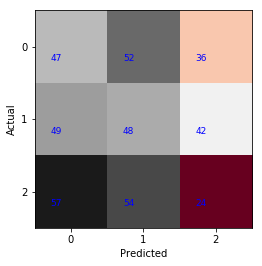

End:  13:39:10 03/13/18 UTC
Start:  13:39:10 03/13/18 UTC
2016-07-18 2003-11-26 2015-03-12 2015-04-10 2016-06-17
2016-07-18 (59523, 78) (6544, 78) (409, 78)
(0, 'begin', array([[ 0.06095818, -0.09526846,  0.25971842]], dtype=float32))


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

Early stopping at epoch   14: Best epoch    4: Validation error: 66.7% 
(0, 'last', array([[ 0.06208469, -0.09937675,  0.26257163]], dtype=float32))
Test_error: 65.3%
             precision    recall  f1-score   support

          0       0.34      0.18      0.23       135
          1       0.34      0.66      0.45       139
          2       0.38      0.19      0.25       135

avg / total       0.35      0.35      0.31       409

[[24 92 19]
 [23 92 24]
 [24 85 26]]


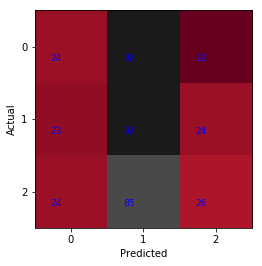

End:  13:42:03 03/13/18 UTC
Start:  13:42:03 03/13/18 UTC
2016-08-15 2003-11-26 2015-04-10 2015-05-08 2016-07-18
2016-08-15 (59937, 78) (6544, 78) (409, 78)
(0, 'begin', array([[ 0.06208469, -0.09937675,  0.26257163]], dtype=float32))


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

Early stopping at epoch   17: Best epoch    7: Validation error: 66.8% 
(0, 'last', array([[ 0.06055338, -0.09575157,  0.26037824]], dtype=float32))
Test_error: 71.6%
             precision    recall  f1-score   support

          0       0.29      0.15      0.20       135
          1       0.22      0.23      0.23       139
          2       0.33      0.47      0.39       135

avg / total       0.28      0.28      0.27       409

[[20 61 54]
 [30 32 77]
 [20 51 64]]


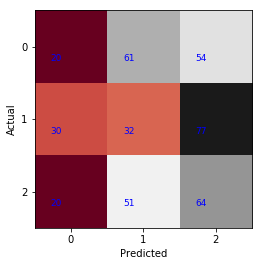

End:  13:45:11 03/13/18 UTC
Start:  13:45:11 03/13/18 UTC
2016-09-13 2003-11-26 2015-04-10 2015-05-08 2016-08-15
2016-09-13 (59937, 78) (6953, 78) (409, 78)
(0, 'begin', array([[ 0.06055338, -0.09575157,  0.26037824]], dtype=float32))


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

Early stopping at epoch   11: Best epoch    1: Validation error: 67.0% 
(0, 'last', array([[ 0.06216724, -0.09876378,  0.26173842]], dtype=float32))
Test_error: 65.5%
             precision    recall  f1-score   support

          0       0.39      0.18      0.24       135
          1       0.34      0.45      0.39       139
          2       0.34      0.40      0.37       135

avg / total       0.36      0.34      0.33       409

[[24 60 51]
 [21 63 55]
 [16 65 54]]


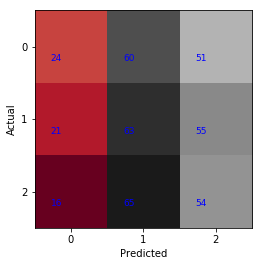

End:  13:48:07 03/13/18 UTC
Start:  13:48:07 03/13/18 UTC
2016-10-11 2003-11-26 2015-05-08 2015-06-08 2016-09-13
2016-10-11 (60354, 78) (6953, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.06216724, -0.09876378,  0.26173842]], dtype=float32))
Early stopping at epoch   12: Best epoch    2: Validation error: 67.2% 
(0, 'last', array([[ 0.06017205, -0.09679566,  0.26169544]], dtype=float32))
Test_error: 69.4%
             precision    recall  f1-score   support

          0       0.31      0.61      0.41       137
          1       0.36      0.15      0.21       136
          2       0.26      0.16      0.20       136

avg / total       0.31      0.31      0.27       409

[[83 16 38]
 [91 20 25]
 [95 19 22]]


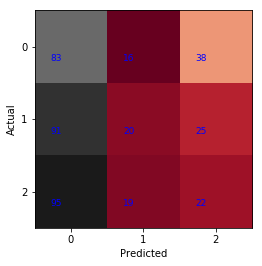

End:  13:51:01 03/13/18 UTC
Start:  13:51:01 03/13/18 UTC
2016-11-08 2003-11-26 2015-06-08 2015-07-07 2016-10-11
2016-11-08 (60771, 78) (6953, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.06017205, -0.09679566,  0.26169544]], dtype=float32))
Early stopping at epoch   14: Best epoch    4: Validation error: 67.2% 
(0, 'last', array([[ 0.05671776, -0.08842567,  0.25659966]], dtype=float32))
Test_error: 68.2%
             precision    recall  f1-score   support

          0       0.31      0.25      0.28       135
          1       0.35      0.56      0.43       139
          2       0.23      0.13      0.17       135

avg / total       0.30      0.32      0.29       409

[[34 58 43]
 [44 78 17]
 [32 85 18]]


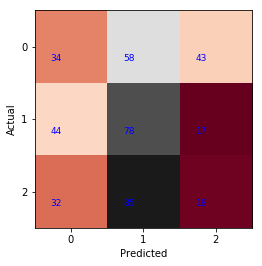

End:  13:54:05 03/13/18 UTC
Start:  13:54:05 03/13/18 UTC
2016-12-07 2003-11-26 2015-07-07 2015-08-04 2016-11-08
2016-12-07 (61188, 78) (6953, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.05671776, -0.08842567,  0.25659966]], dtype=float32))
Early stopping at epoch   11: Best epoch    1: Validation error: 67.6% 
(0, 'last', array([[ 0.05949765, -0.08834751,  0.25376332]], dtype=float32))
Test_error: 64.5%
             precision    recall  f1-score   support

          0       0.31      0.23      0.26       135
          1       0.37      0.37      0.37       139
          2       0.37      0.47      0.41       135

avg / total       0.35      0.35      0.35       409

[[31 51 53]
 [35 51 53]
 [35 37 63]]


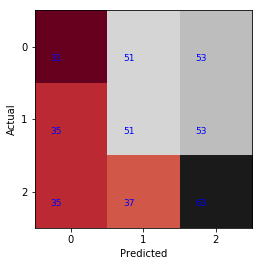

End:  13:57:07 03/13/18 UTC
Start:  13:57:07 03/13/18 UTC
2017-01-06 2003-11-26 2015-08-04 2015-09-01 2016-12-07
2017-01-06 (61605, 78) (6953, 78) (409, 78)
(0, 'begin', array([[ 0.05949765, -0.08834751,  0.25376332]], dtype=float32))


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

Early stopping at epoch   13: Best epoch    3: Validation error: 67.4% 
(0, 'last', array([[ 0.05570327, -0.08922686,  0.2584205 ]], dtype=float32))
Test_error: 68.9%
             precision    recall  f1-score   support

          0       0.38      0.11      0.17       135
          1       0.25      0.17      0.21       139
          2       0.32      0.65      0.43       135

avg / total       0.32      0.31      0.27       409

[[ 15  37  83]
 [ 12  24 103]
 [ 13  34  88]]


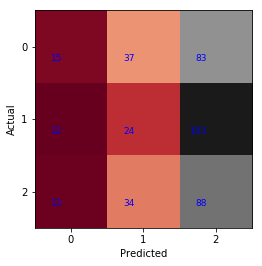

End:  14:00:14 03/13/18 UTC
Start:  14:00:14 03/13/18 UTC
2017-02-06 2003-11-26 2015-09-01 2015-09-30 2017-01-06
2017-02-06 (62022, 78) (6953, 78) (409, 78)
(0, 'begin', array([[ 0.05570327, -0.08922686,  0.2584205 ]], dtype=float32))


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

Early stopping at epoch   19: Best epoch    9: Validation error: 67.8% 
(0, 'last', array([[ 0.05167399, -0.08914406,  0.26222458]], dtype=float32))
Test_error: 63.8%
             precision    recall  f1-score   support

          0       0.37      0.33      0.35       135
          1       0.33      0.20      0.25       138
          2       0.37      0.57      0.45       136

avg / total       0.36      0.36      0.35       409

[[44 26 65]
 [44 27 67]
 [31 28 77]]


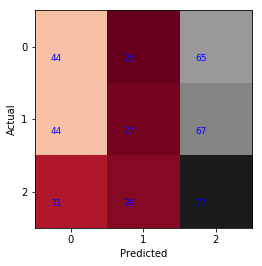

End:  14:03:21 03/13/18 UTC
Start:  14:03:21 03/13/18 UTC
2017-03-07 2003-11-26 2015-09-30 2015-10-28 2017-02-06
2017-03-07 (62439, 78) (6953, 78) (409, 78)
(0, 'begin', array([[ 0.05167399, -0.08914406,  0.26222458]], dtype=float32))


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

Early stopping at epoch   15: Best epoch    5: Validation error: 67.5% 
(0, 'last', array([[ 0.05351577, -0.08025757,  0.25113297]], dtype=float32))
Test_error: 69.2%
             precision    recall  f1-score   support

          0       0.28      0.49      0.36       136
          1       0.30      0.24      0.27       138
          2       0.43      0.19      0.27       135

avg / total       0.34      0.31      0.30       409

[[67 50 19]
 [90 33 15]
 [83 26 26]]


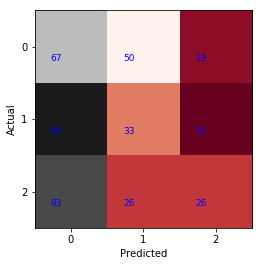

End:  14:06:23 03/13/18 UTC
Start:  14:06:23 03/13/18 UTC
2017-04-04 2003-11-26 2015-10-28 2015-11-25 2017-03-07
2017-04-04 (62856, 78) (6953, 78) (409, 78)
(0, 'begin', array([[ 0.05351577, -0.08025757,  0.25113297]], dtype=float32))


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

Early stopping at epoch   24: Best epoch   14: Validation error: 67.5% 
(0, 'last', array([[ 0.05546594, -0.07971969,  0.24794349]], dtype=float32))
Test_error: 64.1%
             precision    recall  f1-score   support

          0       0.35      0.24      0.29       135
          1       0.37      0.54      0.44       139
          2       0.35      0.29      0.32       135

avg / total       0.36      0.36      0.35       409

[[33 68 34]
 [26 75 38]
 [36 60 39]]


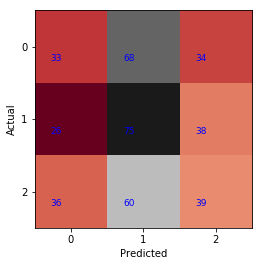

End:  14:09:43 03/13/18 UTC
Start:  14:09:43 03/13/18 UTC
2017-05-02 2003-11-26 2015-11-25 2015-12-24 2017-04-04
2017-05-02 (63273, 78) (6953, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.05546594, -0.07971969,  0.24794349]], dtype=float32))
Early stopping at epoch   11: Best epoch    1: Validation error: 67.2% 
(0, 'last', array([[ 0.05712637, -0.07950195,  0.24608248]], dtype=float32))
Test_error: 67.7%
             precision    recall  f1-score   support

          0       0.36      0.36      0.36       135
          1       0.32      0.09      0.14       139
          2       0.30      0.52      0.38       135

avg / total       0.33      0.32      0.29       409

[[49 15 71]
 [36 13 90]
 [52 13 70]]


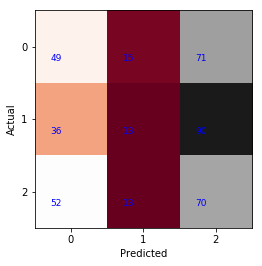

End:  14:12:51 03/13/18 UTC
Start:  14:12:51 03/13/18 UTC
2017-05-31 2003-11-26 2015-12-24 2016-01-26 2017-05-02
2017-05-31 (63690, 78) (6953, 78) (409, 78)
(0, 'begin', array([[ 0.05712637, -0.07950195,  0.24608248]], dtype=float32))


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

Early stopping at epoch   25: Best epoch   15: Validation error: 66.8% 
(0, 'last', array([[ 0.04301513, -0.07680693,  0.25643662]], dtype=float32))
Test_error: 65.3%
             precision    recall  f1-score   support

          0       0.36      0.25      0.30       135
          1       0.35      0.44      0.39       139
          2       0.34      0.35      0.34       135

avg / total       0.35      0.35      0.34       409

[[34 59 42]
 [28 61 50]
 [33 55 47]]


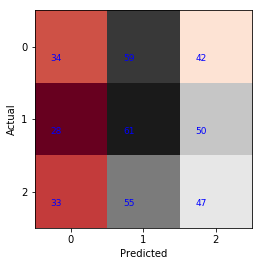

End:  14:16:11 03/13/18 UTC
Start:  14:16:11 03/13/18 UTC
2017-06-28 2003-11-26 2015-12-24 2016-01-26 2017-05-31
2017-06-28 (63690, 78) (7362, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.04301513, -0.07680693,  0.25643662]], dtype=float32))
Early stopping at epoch   22: Best epoch   12: Validation error: 66.7% 
(0, 'last', array([[ 0.04075257, -0.07658967,  0.25763112]], dtype=float32))
Test_error: 66.3%
             precision    recall  f1-score   support

          0       0.30      0.30      0.30       135
          1       0.46      0.30      0.37       138
          2       0.30      0.40      0.35       136

avg / total       0.36      0.34      0.34       409

[[41 18 76]
 [46 42 50]
 [50 31 55]]


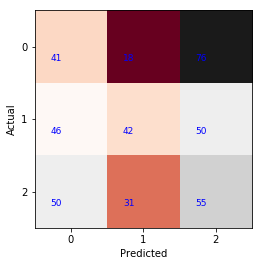

End:  14:19:41 03/13/18 UTC
Start:  14:19:41 03/13/18 UTC
2017-07-27 2003-11-26 2016-01-26 2016-02-24 2017-06-28
2017-07-27 (64104, 78) (7362, 78) (409, 78)
(0, 'begin', array([[ 0.04075257, -0.07658967,  0.25763112]], dtype=float32))


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

Early stopping at epoch   15: Best epoch    5: Validation error: 66.6% 
(0, 'last', array([[ 0.03953107, -0.0760307 ,  0.25801113]], dtype=float32))
Test_error: 66.0%
             precision    recall  f1-score   support

          0       0.32      0.30      0.31       135
          1       0.37      0.52      0.43       139
          2       0.31      0.20      0.24       135

avg / total       0.33      0.34      0.33       409

[[40 64 31]
 [37 72 30]
 [49 59 27]]


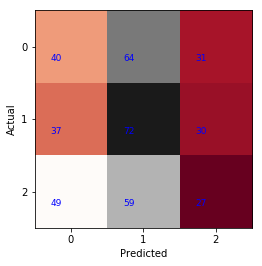

End:  14:22:59 03/13/18 UTC
Start:  14:22:59 03/13/18 UTC
2017-08-24 2003-11-26 2016-02-24 2016-03-23 2017-07-27
2017-08-24 (64521, 78) (7362, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.03953107, -0.0760307 ,  0.25801113]], dtype=float32))
Early stopping at epoch   17: Best epoch    7: Validation error: 66.7% 
(0, 'last', array([[ 0.03724626, -0.08239638,  0.26675475]], dtype=float32))
Test_error: 66.7%
             precision    recall  f1-score   support

          0       0.25      0.11      0.15       135
          1       0.39      0.42      0.41       139
          2       0.31      0.46      0.37       135

avg / total       0.32      0.33      0.31       409

[[15 39 81]
 [23 59 57]
 [21 52 62]]


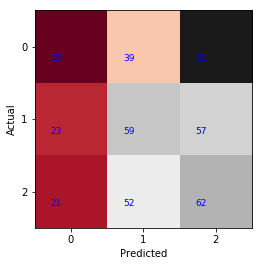

End:  14:26:30 03/13/18 UTC
Start:  14:26:30 03/13/18 UTC
2017-09-22 2003-11-26 2016-03-23 2016-04-21 2017-08-24
2017-09-22 (64935, 78) (7362, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.03724626, -0.08239638,  0.26675475]], dtype=float32))
Early stopping at epoch   29: Best epoch   19: Validation error: 66.4% 
(0, 'last', array([[ 0.04393192, -0.08774911,  0.2648271 ]], dtype=float32))
Test_error: 67.2%
             precision    recall  f1-score   support

          0       0.32      0.48      0.39       135
          1       0.31      0.17      0.22       139
          2       0.34      0.34      0.34       135

avg / total       0.33      0.33      0.31       409

[[65 29 41]
 [69 23 47]
 [67 22 46]]


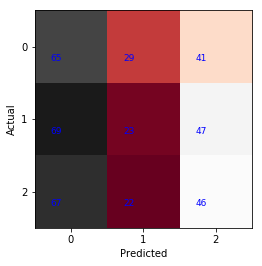

End:  14:30:11 03/13/18 UTC
Start:  14:30:11 03/13/18 UTC
2017-10-20 2003-11-26 2016-04-21 2016-05-19 2017-09-22
2017-10-20 (65352, 78) (7362, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.04393192, -0.08774911,  0.2648271 ]], dtype=float32))
Early stopping at epoch   12: Best epoch    2: Validation error: 66.3% 
(0, 'last', array([[ 0.04275608, -0.08900312,  0.26712728]], dtype=float32))
Test_error: 63.3%
             precision    recall  f1-score   support

          0       0.37      0.27      0.31       135
          1       0.35      0.60      0.44       139
          2       0.43      0.22      0.29       135

avg / total       0.38      0.37      0.35       409

[[37 78 20]
 [37 83 19]
 [27 78 30]]


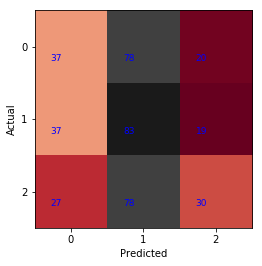

End:  14:34:02 03/13/18 UTC
Start:  14:34:02 03/13/18 UTC
2017-11-20 2003-11-26 2016-05-19 2016-06-17 2017-10-20
2017-11-20 (65769, 78) (7362, 78) (409, 78)
(0, 'begin', array([[ 0.04275608, -0.08900312,  0.26712728]], dtype=float32))


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

Early stopping at epoch   14: Best epoch    4: Validation error: 66.5% 
(0, 'last', array([[ 0.03667516, -0.0800643 ,  0.26391166]], dtype=float32))
Test_error: 65.8%
             precision    recall  f1-score   support

          0       0.26      0.24      0.25       135
          1       0.32      0.15      0.21       139
          2       0.39      0.64      0.49       135

avg / total       0.33      0.34      0.31       409

[[32 32 71]
 [54 21 64]
 [36 12 87]]


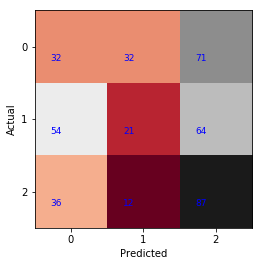

End:  14:37:22 03/13/18 UTC
Start:  14:37:22 03/13/18 UTC
2017-12-19 2003-11-26 2016-06-17 2016-07-18 2017-11-20
2017-12-19 (66186, 78) (7362, 78) (409, 78)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The bina

(0, 'begin', array([[ 0.03667516, -0.0800643 ,  0.26391166]], dtype=float32))
Early stopping at epoch   11: Best epoch    1: Validation error: 66.4% 
(0, 'last', array([[ 0.03818884, -0.0752819 ,  0.25776988]], dtype=float32))
Test_error: 68.0%
             precision    recall  f1-score   support

          0       0.32      0.34      0.33       135
          1       0.28      0.33      0.30       139
          2       0.39      0.29      0.33       135

avg / total       0.33      0.32      0.32       409

[[46 63 26]
 [59 46 34]
 [41 55 39]]


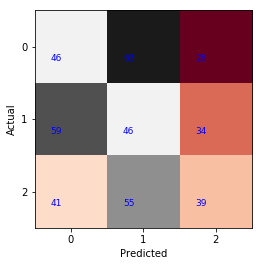

End:  14:41:04 03/13/18 UTC


In [27]:
# First, identify train and validation sets (80% of all data for the two)
# Train the initial model using these data sets
# Then, for the sequence of test dates,
#   1- evaluate the current model, 
#   2- expand train/validate set to include the last test date,
#   3- retrain the model using the new train/validate sets 

dates = dflong['Date'].drop_duplicates()
dates = sorted(dates)
trval_dates = sorted(dates[ : int(len(dates) * .80)]) # Initial training plus validation dates
#trval_dates =  [i for i in dates if i < '2016-06-17']
test_dates = sorted(set(dates) - set(trval_dates)) # All test dates
 
new = 1 # Output file: create for first date, then keep on appending

for testdate in test_dates: 
    tf.set_random_seed(30)
    random.seed(30) 
    np.random.seed(30)
    
    print "Start: ", (time.strftime('%X %x %Z'))
    create_datasets(trval_dates, testdate)
    #print train_data.shape, train_labels.shape, \
    # validation_data.shape, validation_labels.shape, test_data.shape, test_labels.shape
    print testdate, train_data.shape, validation_data.shape, test_data.shape

    num_epochs = 100
    m = train_data.shape[0] # number of training examples
    n_x = train_data.shape[1] # number of features 
    n_y = train_labels.shape[1] # number of outputs: 0/1/2 for Down/Mid/Up

    minibatch_size = 64
    l_rate = 0.0001
    n_l = 66
    activation = 'tanh'

    # This is where training samples and labels are fed to the graph.
    # These placeholder nodes will be fed a batch of training data at each
    # training step, which we'll write once we define the graph structure.
    train_data_node = tf.placeholder(tf.float32, shape=(minibatch_size, n_x))
    train_labels_node = tf.placeholder(tf.float32, shape=(minibatch_size, n_y))

    # For the test data, we'll just hold the entire dataset in one constant node.
    validation_data_node = tf.cast(tf.constant(validation_data), tf.float32)
    test_data_node = tf.cast(tf.constant(test_data), tf.float32)
    
    init_xavier = tf.contrib.layers.xavier_initializer()
    init_zeros = tf.zeros_initializer()
    fc1_weights = tf.Variable(init_xavier([n_x, n_l])) 
    fc1_biases = tf.Variable(init_zeros([n_l]))
    fc2_weights = tf.Variable(init_xavier([n_l, n_y]))
    fc2_biases = tf.Variable(init_zeros([n_y]))

    # Training computation: logits + cross-entropy loss.
    logits = model(train_data_node, activation, True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels = train_labels_node, logits=logits))

    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                    tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
    # Add the regularization term to the loss.
    loss += 0.0001 * regularizers

    optimizer = tf.train.AdamOptimizer(l_rate, 0.9).minimize(loss) 

    # Predictions for the minibatch and test set.
    train_prediction = tf.nn.softmax(logits)
    validation_prediction = tf.nn.softmax(model(validation_data_node, activation))
    test_prediction = tf.nn.softmax(model(test_data_node, activation))

    # Create a new interactive session that we'll use in
    # subsequent code cells.
    sess = tf.InteractiveSession()

    # Use our newly created session as the default for 
    # subsequent operations.
    sess.as_default()
    saver = tf.train.Saver()
    # Initialize all the variables we defined above.
    tf.global_variables_initializer().run()
    if new == 0:                               # After the first test date, use the best model                                    
        saver.restore(sess,'model/mar02')      # from the previous date to get the training started  
    
    # Early stopping implemented from Goodfellow et al (p270)
    # Note: my version monitors test set accuracy
    # as opposed to validation set error in the book
    # e_ denotes a variable used in early stopping algorithm

    e_i = 0    
    e_j = 0
    e_vstar = 1 * np.inf # lowest validation set accuracy
    e_istar = e_i
    e_p = 10  # patience
    e_n = 1   # number of steps between evaluations

    print (new, 'begin', fc2_weights.eval()[0:1,])
    num_minibatches = int(train_data.shape[0] / minibatch_size)        
    for epoch in range(num_epochs):
        b_list = list(range(0, num_minibatches))
        random.shuffle(b_list)

        for i in b_list:   
            batch_data = train_data[i:i+minibatch_size, :]
            batch_labels = train_labels[i:i+minibatch_size]
            feed_dict = {train_data_node: batch_data, train_labels_node: batch_labels}
            # Run the graph and fetch some of the nodes.
            _, l, predictions = sess.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if epoch % e_n == 0:
            error, _ = error_rate(predictions, batch_labels)
            e_v, _ = error_rate(validation_prediction.eval(), validation_labels)
            #print('Epoch %d of %d MB loss: %.5f MB error: %.5f Validation error: %.1f%%' % 
            #      (epoch, num_epochs, l, error, e_v))

            # Early stopping test  
            e_i += e_n
            if e_v < e_vstar:
                e_j = 0
                e_istar = e_i
                e_vstar = e_v
                saver.save(sess, 'model/mar02') # Current best model
            else:
                e_j += 1
            if e_j > e_p:
                print ("Early stopping at epoch %4i: Best epoch %4i: Validation error: %.1f%% " % 
                       (epoch, e_istar, e_vstar))
                break
    saver.restore(sess, 'model/mar02') # Best model from all epochs on this testdate
    saver.save(sess, 'model/mar02')
    print (new, 'last', fc2_weights.eval()[0:1,])
    test_error, _ = error_rate(test_prediction.eval(), test_labels)
    print ("Test_error: %.1f%%" % (test_error))
    
    # Model performance
    show_results(test_labels, test_prediction.eval())
    
    # Model predicted probabilities and outcome
    columns = ['pr_0','pr_1','pr_2']
    pred_df = pd.DataFrame(test_prediction.eval(),columns=columns)
    pred_df['Y_pred'] = np.argmax(test_prediction.eval(),1)
    pred_df.reset_index(drop=True, inplace=True)  

    # Output data set includes this month's and next month's returns
    inp_data = dflong[dflong['Date'] == testdate][id_cols + other_cols + y_col]
    inp_data.reset_index(drop=True, inplace=True)

    out_df = pd.concat([inp_data, pred_df], axis=1) # This took a long time 

    # Benchmark predictions

    # Momentum and reversal
    # Momentum: predict 2 for this month's 2
    # Reversal: predict 0 for this month's 2
    # Use 33% and 67% cutoffs to obtain three-level prediction
    out_df['Q33'] = out_df.groupby(['Date'])['R'].transform(lambda x: x.quantile(.33))
    out_df['Q67'] = out_df.groupby(['Date'])['R'].transform(lambda x: x.quantile(.67))
    out_df['Y_mom'] = 1 # default
    out_df['Y_mom'][out_df['R'] >= out_df['Q67']] = 2
    out_df['Y_mom'][out_df['R'] <= out_df['Q33']] = 0

    out_df['Y_rev'] = 1 # default
    out_df['Y_rev'][out_df['R'] >= out_df['Q67']] = 0
    out_df['Y_rev'][out_df['R'] <= out_df['Q33']] = 2
    out_df.drop(['Q33','Q67'], axis = 1, inplace=True)

    # Randomly select Down/Mid/Up or Down/Up
    out_df['Y_rand3'] = np.random.randint(3, size=out_df.shape[0]) # Down/Mid/Up
    out_df['Y_rand2'] = np.random.randint(2, size=out_df.shape[0])*2 
    # Down/Up only: 0s remain 0s, 1s become 2s

    if new == 1:
        out_df.to_csv('SP500_Results_V3.CSV', index = False, float_format='%.4f')
        new = 0
    else:
        out_df.to_csv('SP500_Results_V3.CSV', index = False, mode = 'a', header = False, float_format='%.4f')
    
    trval_dates.append(testdate)
    print "End: ", (time.strftime('%X %x %Z'))
    tf.reset_default_graph()

## Functions


In [14]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    C = tf.constant(C, name='C')   
    one_hot_matrix = tf.one_hot(labels, C,  axis = 1) #axis = 0) 
        # each row is one observation, thus axis = 1
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix) 
    sess.close()
    
    return one_hot

In [15]:
def create_datasets(trval_dates, testdate):
    global train_data, train_labels, validation_data, validation_labels, test_data, test_labels
    train_dates = sorted(trval_dates[ : int(len(trval_dates) * .90)])
    validation_dates = sorted(set(trval_dates) - set(train_dates))    
    
    train_data = dflong[dflong['Date'].isin(train_dates)][cs_ret + cs_vol + ts_ret + ts_vol].as_matrix()
    train_labels = dflong[dflong['Date'].isin(train_dates)]['Y'].as_matrix() 
   
    #print('Original dataset shape {}'.format(Counter(train_labels)))
    sm = SMOTE(random_state=30)
    train_data, train_labels = sm.fit_sample(train_data, train_labels)
    #print('Resampled dataset shape {}'.format(Counter(train_labels)))
    train_labels = one_hot_matrix(train_labels, 3) #SMOTE already converts the Ys into a "matrix"

    validation_data = dflong[dflong['Date'].isin(validation_dates)][cs_ret + cs_vol + ts_ret + ts_vol].as_matrix()
    validation_labels = one_hot_matrix(dflong[dflong['Date'].isin(validation_dates)]['Y'].as_matrix(), 3)

    test_data = dflong[dflong['Date'] == testdate][cs_ret + cs_vol + ts_ret + ts_vol].as_matrix()
    test_labels = one_hot_matrix(dflong[dflong['Date'] == testdate]['Y'].as_matrix(), 3)
 
    #print train_data.shape, train_labels.shape, validation_data.shape, validation_labels.shape, test_data.shape, test_labels.shape
    print testdate, min(train_dates), max(train_dates), min(validation_dates), max(validation_dates) 
    return

In [16]:
def model(data, activation, train=False):
    hidden = tf.nn.tanh(tf.matmul(data, fc1_weights) + fc1_biases)
    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
        hidden = tf.nn.dropout(hidden, 0.5)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

In [17]:
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([3, 3], np.float32)
    bundled = zip(np.argmax(predictions, 1), np.argmax(labels, 1))
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

In [18]:
def show_results (yhot_true, yhot_pred):
    # Results for momentum/reversal or random assignment
    y_true = np.argmax(yhot_true,1) # Back from one-hot to 0/1/2
    y_pred = np.argmax(yhot_pred,1) 

    print classification_report(y_true, y_pred)
    print confusion_matrix(y_true, y_pred)

    _, confusions = error_rate(yhot_pred, yhot_true)

    # This transpose makes the results in line with scikit confusion matrix
    # Rows are actual and columns are predicted
    confusions =  np.transpose(confusions)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.grid(False)
    plt.xticks(np.arange(yhot_pred.shape[1]))
    plt.yticks(np.arange(yhot_true.shape[1]))
    plt.imshow(confusions, cmap=plt.cm.RdGy, interpolation='nearest')

    for i, cas in enumerate(confusions):
        for j, count in enumerate(cas):
            if count >= 0:
                xoff = .07 * len(str(count))
                plt.text(j-xoff, i+.2, int(count), fontsize=9, color='blue')
    plt.show() 